In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model


In [2]:
# Simulate tabular data
np.random.seed(42)
n_samples = 500
tabular_data = pd.DataFrame({
    'area': np.random.randint(800, 4000, n_samples),
    'bedrooms': np.random.randint(1, 6, n_samples),
    'bathrooms': np.random.randint(1, 4, n_samples),
    'price': np.random.randint(100000, 500000, n_samples)
})

# Simulate image data (random RGB images)
image_data = np.random.rand(n_samples, 64, 64, 3)

# Normalize tabular features
scaler = StandardScaler()
X_tabular = scaler.fit_transform(tabular_data[['area', 'bedrooms', 'bathrooms']])
y = tabular_data['price'].values


In [3]:
X_tab_train, X_tab_test, X_img_train, X_img_test, y_train, y_test = train_test_split(
    X_tabular, image_data, y, test_size=0.2, random_state=42
)


In [4]:
# Tabular input branch
input_tabular = Input(shape=(3,))
x = Dense(64, activation='relu')(input_tabular)
x = Dense(32, activation='relu')(x)

# Image input branch
input_image = Input(shape=(64, 64, 3))
y = Conv2D(32, (3, 3), activation='relu')(input_image)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Flatten()(y)
y = Dense(64, activation='relu')(y)

# Combine both
combined = Concatenate()([x, y])
z = Dense(64, activation='relu')(combined)
z = Dense(1)(z)

# Build and compile
model = Model(inputs=[input_tabular, input_image], outputs=z)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 62, 62,    │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 31, 31,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 29, 29,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12544)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │    802,880 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 830,881 (3.17 MB)

 Trainable params: 830,881 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = model.fit(
    [X_tab_train, X_img_train], y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32
)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 108117057536.0000 - mae: 307526.0312 - val_loss: 110840070144.0000 - val_mae: 314702.0312
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 105622970368.0000 - mae: 303914.3750 - val_loss: 109751812096.0000 - val_mae: 312968.5625
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 102781460480.0000 - mae: 300618.3438 - val_loss: 104092270592.0000 - val_mae: 303794.1875
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 92470452224.0000 - mae: 282854.1250 - val_loss: 84011687936.0000 - val_mae: 268727.5938
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 69711224832.0000 - mae: 238003.6875 - val_loss: 38646497280.0000 - val_mae: 167224.4688
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 27353114624.0000 - mae: 135146.8438 - val_loss: 13041491968.0000 - val_mae: 90972.3672
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 16636185600.0000 - mae: 109112.9375 - val_loss: 117

In [6]:
# Predict and evaluate
y_pred = model.predict([X_tab_test, X_img_test])
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:,.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Test MAE: 97,405.22


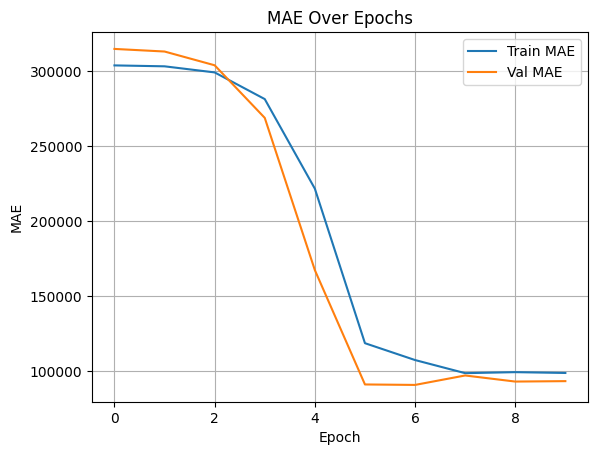

In [7]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()


In [8]:
model.save("multimodal_house_price_model.h5")
